Paper we are following: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Difference: we are building a character-level model while they built a word level model. Our implementation will be the same, however

Notes:
For each word they associated a 30 dimensional feature vector
Tune the embeddings of these words so they are grouped - for instance words that have similar meanings will get closer in the space, and words with diffferent meanings will move apart
Use multilayer neural net to predict next word
train using neg log likelihood loss

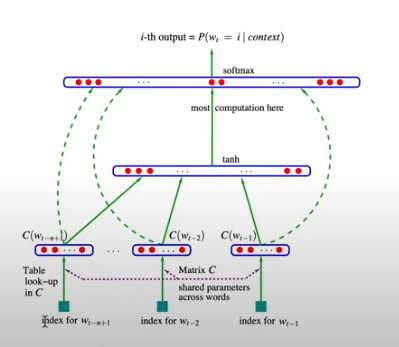

embedding lookup table C is 30x17000 (for their 17000 words) for each word we pluck out the row of the lookup the table for that word and then we get its embedding. 
C is shared accross all three input words.
parameters are weights and biases of softmax layer weights and biases of tanh layer, and embedding lookup table C

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
#build vocabulary of characters and mappings to/from integers
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
#build dataset

block_size=3 #context length: how many characters do we take in to predict the next one
X,Y=[],[]

for w in words[:5]:
    print(w)
    context=[0]*block_size
    for ch in w+'.':
        ix=stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context),'---->',itos[ix])
        context=context[1:]+[ix] #crop and append
X=torch.tensor(X)
Y=torch.tensor(Y)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [6]:
X.shape, X.dtype, Y.shape,  Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [8]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [9]:
C=torch.randn((27,2)) #embed our 27 characters into a 2 dimensional space 
C[5]

tensor([0.4066, 2.1849])

In [10]:
#onehot encoding
F.one_hot(torch.tensor(5),num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [11]:
F.one_hot(torch.tensor(5),num_classes=27).float()@C

tensor([0.4066, 2.1849])

Notice output is identical

We'll take the indexing appproach since its faster

In [12]:
C[X]

tensor([[[ 0.4740,  0.6615],
         [ 0.4740,  0.6615],
         [ 0.4740,  0.6615]],

        [[ 0.4740,  0.6615],
         [ 0.4740,  0.6615],
         [ 0.4066,  2.1849]],

        [[ 0.4740,  0.6615],
         [ 0.4066,  2.1849],
         [-0.4056,  0.4023]],

        [[ 0.4066,  2.1849],
         [-0.4056,  0.4023],
         [-0.4056,  0.4023]],

        [[-0.4056,  0.4023],
         [-0.4056,  0.4023],
         [ 0.3192,  1.0632]],

        [[ 0.4740,  0.6615],
         [ 0.4740,  0.6615],
         [ 0.4740,  0.6615]],

        [[ 0.4740,  0.6615],
         [ 0.4740,  0.6615],
         [-0.6853, -0.5604]],

        [[ 0.4740,  0.6615],
         [-0.6853, -0.5604],
         [-0.4991,  1.2494]],

        [[-0.6853, -0.5604],
         [-0.4991,  1.2494],
         [ 0.8823, -0.1773]],

        [[-0.4991,  1.2494],
         [ 0.8823, -0.1773],
         [-0.3863,  0.6528]],

        [[ 0.8823, -0.1773],
         [-0.3863,  0.6528],
         [ 0.8823, -0.1773]],

        [[-0.3863,  0

In [13]:
C[X].shape

torch.Size([32, 3, 2])

In [14]:
X[13,2]

tensor(1)

In [15]:
C[X][13,2]

tensor([0.3192, 1.0632])

In [16]:
C[1]

tensor([0.3192, 1.0632])

Pytorch indexing is awesome

In [18]:
emb=C[X]
emb.shape

torch.Size([32, 3, 2])

In [19]:
#hidden (Tanh) layer
W1=torch.randn((6,100)) #number inputs 3*2=6, numberof neurons - variable, let's use 100
b1=torch.randn(100)

In [ ]:
emb @ W1 +b1 #doesn't run because torch multiplies the 32*3 to make it 96x2 but we need it to be 32xy

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [22]:
#we could do this but it won't generalize to different block sizes
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape

torch.Size([32, 6])

In [24]:
#generalize
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([32, 6])

In [ ]:
#better generalization
#torch stores tensors as a 1D tensor and you can change the internal attributes to change how the tensor is viewed. Changing the view of the tensor doesn't change the storage

emb.view(32,6).shape

#notice the concat is also less efficient bc it creates a whole new tensor and new memory

torch.Size([32, 6])

In [27]:
torch.allclose(emb.view(32,6),torch.cat(torch.unbind(emb,1),1))

True

In [28]:
h=torch.tanh(emb.view(-1,6) @ W1 +b1) #-1 makes pytorch infer what it should be

In [29]:
h

tensor([[-0.5228,  0.6675,  0.9960,  ..., -0.9415,  0.1187,  0.9806],
        [-0.9975,  0.8736,  0.9997,  ..., -0.9733, -0.8249,  0.9923],
        [-0.9960, -0.7818,  0.9998,  ..., -0.9738, -0.9489,  0.9999],
        ...,
        [-0.9704,  0.5711,  0.9053,  ..., -0.8726, -0.1521, -0.8907],
        [-0.8732,  0.9427,  0.0465,  ..., -0.0449, -0.1182, -0.7535],
        [-0.9744,  0.8131,  0.8125,  ..., -0.9979,  0.9403,  0.5584]])

In [30]:
h.shape

torch.Size([32, 100])

In [ ]:
#check broadcasting of the + above
#32, 100
# 1, 100
#broadcasting aligns on right, creates a fake row, and then copies accross, so we are good.

In [32]:
#create logits and probs for  softmax layer
W2=torch.randn(100,27) #100 inputs from tanh, 27 possible characters out
b2 = torch.randn(27)

In [33]:
logits = h @ W2 +b2

In [34]:
logits.shape

torch.Size([32, 27])

In [37]:
counts=logits.exp()
prob=counts/counts.sum(1,keepdims=True)

In [38]:
prob.shape

torch.Size([32, 27])

In [ ]:
#now we need Y which holds the correct next character
prob[torch.arange(32),Y] #probability for correct next character

tensor([1.0568e-04, 1.6727e-06, 3.2118e-02, 5.8019e-06, 8.0116e-05, 6.0130e-03,
        7.4811e-11, 1.7319e-04, 8.5881e-11, 2.7442e-06, 2.5365e-10, 9.9418e-02,
        1.5381e-11, 2.9058e-05, 1.8671e-06, 2.7138e-01, 1.4208e-12, 2.9210e-07,
        3.2169e-05, 7.8689e-02, 2.5082e-14, 2.2213e-05, 7.0545e-11, 2.1484e-07,
        2.5006e-02, 4.7991e-07, 9.9032e-05, 8.5145e-11, 5.2263e-07, 1.7035e-13,
        1.8263e-13, 4.3012e-01])

In [41]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [43]:
loss=-prob[torch.arange(32),Y].log().mean()
loss

tensor(14.2300)

Rewrite/Clean-up and looping for forward and backward pass

In [48]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [49]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [55]:
for p in parameters:
    p.requires_grad=True

In [57]:
for _ in range (1000):
    #forward pass
    emb=C[X] #(32,3,2)
    h=torch.tanh(emb.view(-1,6) @ W1 +b1) #(32,100)
    logits = h @ W2 +b2 #(32,27)
    #counts=logits.exp()
    #prob=counts/counts.sum(1, keepdims=True)
    #loss=-prob[torch.arange(32),Y].log().mean()
    loss=F.cross_entropy(logits,Y) #note this does the same thing as commented code but is more efficient and also handles if logit is very large and we run out of range in the exp function
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    for p in parameters:
        p.data+=-0.1*p.grad

print(loss.item())


0.2560844123363495


Can't acheive exactly zero loss because ... can predict lots of letters (first letter of name)
We are getting such a low loss becuase we are overfitting. 32 examples and 3k parameters

Use full data set:

In [85]:
#build dataset

block_size=3 #context length: how many characters do we take in to predict the next one
X,Y=[],[]

for w in words:
    context=[0]*block_size
    for ch in w+'.':
        ix=stoi[ch]
        X.append(context)
        Y.append(ix)
        context=context[1:]+[ix] #crop and append
X=torch.tensor(X)
Y=torch.tensor(Y)

In [60]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
for _ in range (10):
    
    #forward pass
    emb=C[X] #(32,3,2)
    h=torch.tanh(emb.view(-1,6) @ W1 +b1) #(32,100)
    logits = h @ W2 +b2 #(32,27)
    loss=F.cross_entropy(logits,Y) 
    print(loss.item())

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    for p in parameters:
        p.data+=-0.1*p.grad

#print(loss.item())

7.818336486816406
7.68332052230835
7.553862571716309
7.429539680480957
7.309994697570801
7.194919109344482
7.08405065536499
6.977160453796387
6.874052047729492
6.774558067321777


In [ ]:
torch.randint(0,X.shape[0],(32,)) #create random integers to index into our dataset to create minibatches

tensor([ 74484, 183972,  46982,  31513, 214246, 153374,  15635, 221289,  56674,
         68859, 103706, 111853, 158587, 212221, 157566, 142124,   8973, 169916,
         66667, 166196, 142642, 105636,  18389, 158580, 179960,  68540, 201116,
        207439, 214489,  14561, 141213,  95401])

In [73]:
for _ in range(1000):

    #mini batch construct
    ix=torch.randint(0,X.shape[0],(32,))

    #forward pass
    emb=C[X[ix]] #(32,3,2)
    h=torch.tanh(emb.view(-1,6) @ W1 +b1) #(32,100)
    logits = h @ W2 +b2 #(32,27)
    loss=F.cross_entropy(logits,Y[ix]) 
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    for p in parameters:
        p.data+=-0.1*p.grad

#print(loss.item())

Because we are doing mini batches the quality of the gradient is lower, so the direction is not as reliable (its not an actual gradient direction), but the gradient direction is good enough to be useful. Its better (more performant) to have an approximate gradient and take more steps than exact gradient and take fewer steps (obviously still can be a balancing act)

In [74]:
#evaluate loss for total dataset not mini batch
emb=C[X] #(32,3,2)
h=torch.tanh(emb.view(-1,6) @ W1 +b1) #(32,100)
logits = h @ W2 +b2 #(32,27)
loss=F.cross_entropy(logits,Y) 
print(loss.item())

2.5000417232513428


We don't know if our learning rate is good...
p.data+=-0.1*p.grad
p.data+=-0.001*p.grad --> likely learning too slow
p.data+=-1*p.grad --> too fast and loss fluctuates and over corrects

In [75]:
lre=torch.linspace(-3,0,1000)
lrs=10**lre
lrs #candidate learning rates we want to search over

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [83]:
#reset parameters before running this
lri=[]
lossi=[]

for i in range(1000):

    #mini batch construct
    ix=torch.randint(0,X.shape[0],(32,))

    #forward pass
    emb=C[X[ix]] #(32,3,2)
    h=torch.tanh(emb.view(-1,6) @ W1 +b1) #(32,100)
    logits = h @ W2 +b2 #(32,27)
    loss=F.cross_entropy(logits,Y[ix]) 
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    lr =lrs[i]
    for p in parameters:
        p.data+=-lr*p.grad

    #track stats
    lri.append(lre[i])
    lossi.append(loss.item())

#print(loss.item())

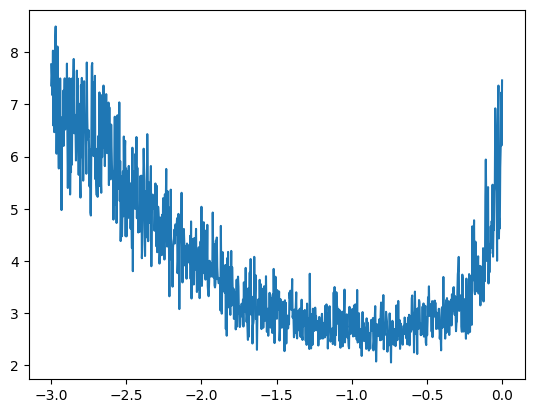

In [84]:
plt.plot(lri,lossi)

lre around -1 seems like a good setting. 10^-1 = .1 so we were good before...

In [86]:
#reset and run a ton at .1 then after a while do a learning rate decay by a factor of 10
for i in range(40000):

    #mini batch construct
    ix=torch.randint(0,X.shape[0],(32,))

    #forward pass
    emb=C[X[ix]] #(32,3,2)
    h=torch.tanh(emb.view(-1,6) @ W1 +b1) #(32,100)
    logits = h @ W2 +b2 #(32,27)
    loss=F.cross_entropy(logits,Y[ix]) 
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    for p in parameters:
        if i<30000:
            p.data+=-0.1*p.grad
        else:
            p.data+=-0.01*p.grad

In [87]:
loss

tensor(2.0727, grad_fn=<NllLossBackward0>)

Standard in the field is to split data set into 3 parts
1. training (80%) - used for training
2. dev/validation (10%) - used to tune hyperparameters
3. test (10%) - used to test

Want to be careful about overfitting too much because if loss ~0 then we have just memorized out training data but loss can e very high on new cases. that is why dev split is important.
Evaluate test loss sparingly otherwise you will just train your model on test set too. then what do you test with.

In [90]:
#build dataset
def build_dataset(words):
    block_size=3 #context length: how many characters do we take in to predict the next one
    X,Y=[],[]

    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix] #crop and append
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(.8*len(words))
n2=int(.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[:n2])
Xte,Yte=build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([205347, 3]) torch.Size([205347])
torch.Size([22799, 3]) torch.Size([22799])


In [91]:
#reset and run a ton at .1 then after a while do a learning rate decay by a factor of 10
for i in range(40000):

    #mini batch construct
    ix=torch.randint(0,Xtr.shape[0],(32,))

    #forward pass
    emb=C[Xtr[ix]] #(32,3,2)
    h=torch.tanh(emb.view(-1,6) @ W1 +b1) #(32,100)
    logits = h @ W2 +b2 #(32,27)
    loss=F.cross_entropy(logits,Ytr[ix]) 
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    for p in parameters:
        if i<30000:
            p.data+=-0.1*p.grad
        else:
            p.data+=-0.01*p.grad

In [93]:
#evaluate training loss
emb=C[Xtr] #(32,3,2)
h=torch.tanh(emb.view(-1,6) @ W1 +b1) #(32,100)
logits = h @ W2 +b2 #(32,27)
loss=F.cross_entropy(logits,Ytr) 
print(loss.item())

2.260830879211426


In [ ]:
#evaluate dev loss
emb=C[Xdev] #(32,3,2)
h=torch.tanh(emb.view(-1,6) @ W1 +b1) #(32,100)
logits = h @ W2 +b2 #(32,27)
loss=F.cross_entropy(logits,Ydev) 
print(loss.item())

2.2616636753082275


training and dev loss are about equal so we aren't overfitting (YAY!)

We are actually underfitting because the training and test/dev losses are roughly equal.

Let's scale up the neural net.

In [98]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad=True
sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [104]:
lossi=[]
stepi=[]

for i in range(30000):

    #mini batch construct
    ix=torch.randint(0,X.shape[0],(32,))

    #forward pass
    emb=C[X[ix]] #(32,3,2)
    h=torch.tanh(emb.view(-1,6) @ W1 +b1) #(32,100)
    logits = h @ W2 +b2 #(32,27)
    loss=F.cross_entropy(logits,Y[ix]) 
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    for p in parameters:
        p.data+=-.1*p.grad

    #track stats

    lossi.append(loss.item())
    stepi.append(i)


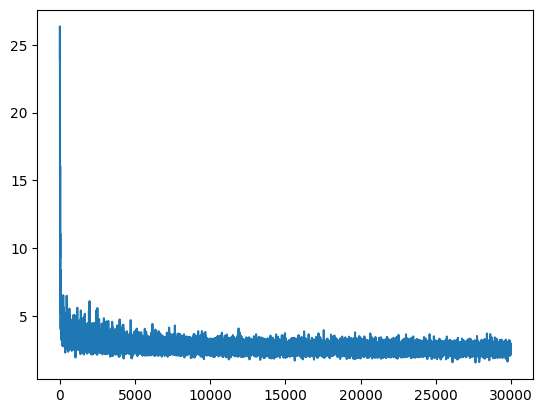

In [100]:
plt.plot(stepi,lossi)

The thickness here comes from the minibatches creating noise

In [105]:
#evaluate dev loss
emb=C[Xdev] #(32,3,2)
h=torch.tanh(emb.view(-1,6) @ W1 +b1) #(32,100)
logits = h @ W2 +b2 #(32,27)
loss=F.cross_entropy(logits,Ydev) 
print(loss.item())

2.410374641418457


After training for a while we will hit a wall around 2.2 loss. Bottleneck is liekley our 2D embedding tables. Let's visualize those before we scale them up.

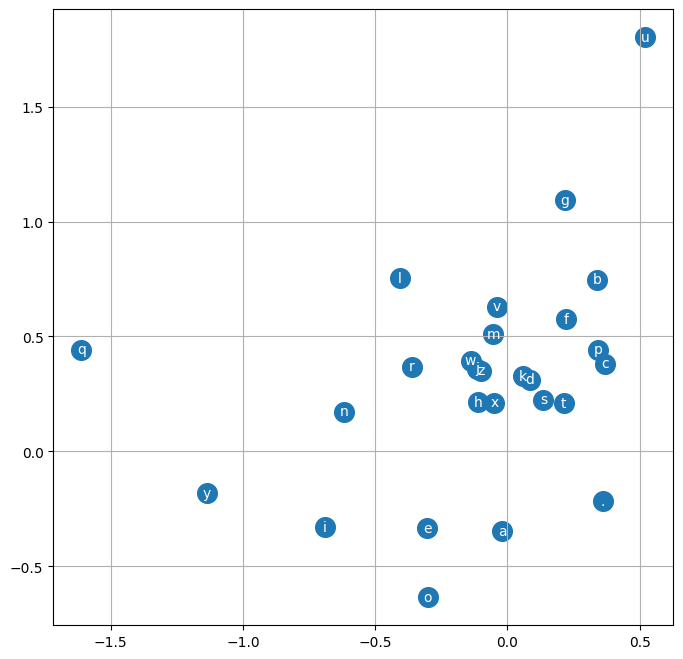

In [108]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),itos[i], ha="center",va="center", color='white')
    plt.grid('minor')

Shows the grouping of what letters are "similar." notice a,e,i,o are seperated from the consonents and sort of grouped together... the model has learned they are special.

In [109]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad=True
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [110]:
lossi=[]
stepi=[]

In [116]:
for i in range(100000):

    #mini batch construct
    ix=torch.randint(0,X.shape[0],(32,))

    #forward pass
    emb=C[X[ix]] #(32,3,2)
    h=torch.tanh(emb.view(-1,W1.shape[0]) @ W1 +b1)
    logits = h @ W2 +b2 
    loss=F.cross_entropy(logits,Y[ix]) 
    #print(loss.item())

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    for p in parameters:
        if i<75000:
            p.data+=-.1*p.grad
        else:
            p.data+=-.01*p.grad

    #track stats

    lossi.append(loss.log10().item())
    stepi.append(i)

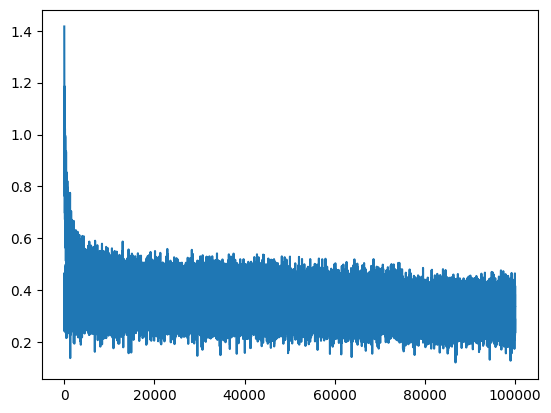

In [117]:
plt.plot(stepi,lossi)

In [118]:
#evaluate training loss
emb=C[Xtr] #(32,3,2)
h=torch.tanh(emb.view(-1,W1.shape[0]) @ W1 +b1) #(32,100)
logits = h @ W2 +b2 #(32,27)
loss=F.cross_entropy(logits,Ytr) 
print(loss.item())

2.1265788078308105


In [119]:
#evaluate dev loss
emb=C[Xdev] #(32,3,2)
h=torch.tanh(emb.view(-1,W1.shape[0]) @ W1 +b1)
logits = h @ W2 +b2
loss=F.cross_entropy(logits,Ydev) 
print(loss.item())

2.1253185272216797


Our training and dev loss are starting to converge, so we are starting to just overfit which is good. We've done the tuning pretty haphazardly and should set a bunch of hyperparameters for our different layer sizes and then run a bunc of experiments to get it lower.

Things we can change:
1. Number of neurons in hidden layer
2. Embedding dimensionality in embedding table
3. Number of characters feeding into the model as the context
4. Change the optimization - how long is it running and how does the learning rate change over time
5. Change the batch size

In [120]:
#sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      if ix == 0:
        break
      context = context[1:] + [ix]
      out.append(ix)
    
    print(''.join(itos[i] for i in out))

mona
mayah
see
mad
ryah
remmadiendraeg
adee
daelin
shi
jenleigh
camanar
kayzion
kalin
shabergahimie
trick
well
panthona
uba
ged
ryyah


Looks much better than the bigram model